In [4]:
import findspark
import findspark
findspark.init()
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
import findspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark

# 1. Import Data Using Infer Schema

In [6]:
#defining file path and type
csv_path = "sample_data/covid_19_202001_202007.csv"
file_type = "csv"

# Set up the parameters

inferSchema = "true"
firstRowHeader = "true"
delimeter = ","

# importing csv 
dataFrame = spark.read.format(file_type).option("inferSchema", inferSchema) \
            .option("header", firstRowHeader) \
            .option("sep", delimeter) \
            .load(csv_path)
dataFrame.head()

Row(Province/State=None, Country/Region='Afghanistan', Lat=33.93911, Long=67.709953, Date='2020-01-22', Confirmed=0, Deaths=0, Recovered=0, Active=0, WHO Region='Eastern Mediterranean')

### Stage Id 2, shows the load time which is 87ms 

<img src="https://github.com/rahibahmed/Assignment1DataCollection/blob/main/InferSchemaLoadTime.png?raw=true" width="800" height="400">

In [7]:
# column name with their data type using inferSchema
for column in dataFrame.dtypes:
    print(column[0]+" , "+column[1])

Province/State , string
Country/Region , string
Lat , double
Long , double
Date , string
Confirmed , int
Deaths , int
Recovered , int
Active , int
WHO Region , string


In [8]:
dataFrame.show(2)

+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|Province/State|Country/Region|     Lat|     Long|      Date|Confirmed|Deaths|Recovered|Active|          WHO Region|
+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
|          null|   Afghanistan|33.93911|67.709953|2020-01-22|        0|     0|        0|     0|Eastern Mediterra...|
|          null|       Albania| 41.1533|  20.1683|2020-01-22|        0|     0|        0|     0|              Europe|
+--------------+--------------+--------+---------+----------+---------+------+---------+------+--------------------+
only showing top 2 rows



# 2. Define Schema and import data 

In [9]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType, FloatType

customSchema = StructType([ 
    StructField("State",StringType(),True), 
    StructField("Country",StringType(),True), 
    StructField("Latitude", FloatType(),True), 
    StructField("Longitude", FloatType(), True), 
    StructField("Date", DateType(), True), 
    StructField("Confirmed", IntegerType(), True),
    StructField("Deaths", IntegerType(), True),
    StructField("Recovered", IntegerType(), True),
    StructField("Active", IntegerType(), True),
    StructField("WHORegion", StringType(), True),
  ])
df = spark.read.load(csv_path, format=file_type, header=firstRowHeader, sep=delimeter, schema=customSchema)
df.head()

Row(State=None, Country='Afghanistan', Latitude=33.939109802246094, Longitude=67.70995330810547, Date=datetime.date(2020, 1, 22), Confirmed=0, Deaths=0, Recovered=0, Active=0, WHORegion='Eastern Mediterranean')

### Stage ID 4, displays the load time duration for customSchema which is 33ms
### Stage ID 3, displays the showString method which is used on In[8]

<img src="https://github.com/rahibahmed/Assignment1DataCollection/blob/main/CustomSchema.png?raw=true" width="800" height="400">

In [15]:
# column name with their data type using customSchema
for column in df.dtypes:
    print(column[0]+" , "+column[1])

State , string
Country , string
Latitude , float
Longitude , float
Date , date
Confirmed , int
Deaths , int
Recovered , int
Active , int
WHORegion , string


# 3. Would you recommend creating a schema first before importing the data? Why?

# Ans

## Yes, creating a schema before importing the data is a good habbit and removes any dataType discrepency from the schema.
## As it can be seen from the example above, creating a inferSchema and loading the csv file resulted in wrong DataType of "Date" column, which is "string" making it harder to operate. On the other hand, creating a custom Schema defining the dataType of "Date" column as DateType, resulted in "date" DataType, as can be seen from the above example making it easier to perform further task.

# 4. Provide summary statistics on the dataset

In [11]:
df.describe().show()

+-------+--------+-----------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+---------------+
|summary|   State|    Country|          Latitude|        Longitude|         Confirmed|           Deaths|        Recovered|           Active|      WHORegion|
+-------+--------+-----------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+---------------+
|  count|   14664|      49068|             49068|            49068|             49068|            49068|            49068|            49068|          49068|
|   mean|    null|       null|21.433730432456823|23.52823646406561| 16884.90425531915|884.1791595337083|7915.713479253282| 8085.01161653216|           null|
| stddev|    null|       null|24.950319775168307|70.44273974868658|127300.20527228026|6313.584410596534|54800.91873054013|76258.90302550694|           null|
|    min| Alberta|Afghanistan|          -51.7963|         

# 5. For top 10 countries suffering from covid-19, plot the line charts to show the deaths from Jan 22, 2020 to July 27, 2020?

In [16]:
# Creating a Temp View and tied it to the spark session
df.createOrReplaceTempView("covidSuffering")

In [17]:
suffer = spark.sql("SELECT Country, SUM(Deaths) as totalDeaths FROM covidSuffering WHERE Date BETWEEN '2020-01-22' AND '2020-07-27' GROUP BY Country ORDER BY totalDeaths DESC LIMIT 10")
suffer.show() 

+--------------+-----------+
|       Country|totalDeaths|
+--------------+-----------+
|            US|   11011411|
|United Kingdom|    3997775|
|        Brazil|    3938034|
|         Italy|    3707717|
|        France|    3048524|
|         Spain|    3033030|
|        Mexico|    1728277|
|         India|    1111831|
|          Iran|    1024136|
|       Belgium|     963679|
+--------------+-----------+



In [19]:
# display the type of dataframe
type(suffer.take(10))

list

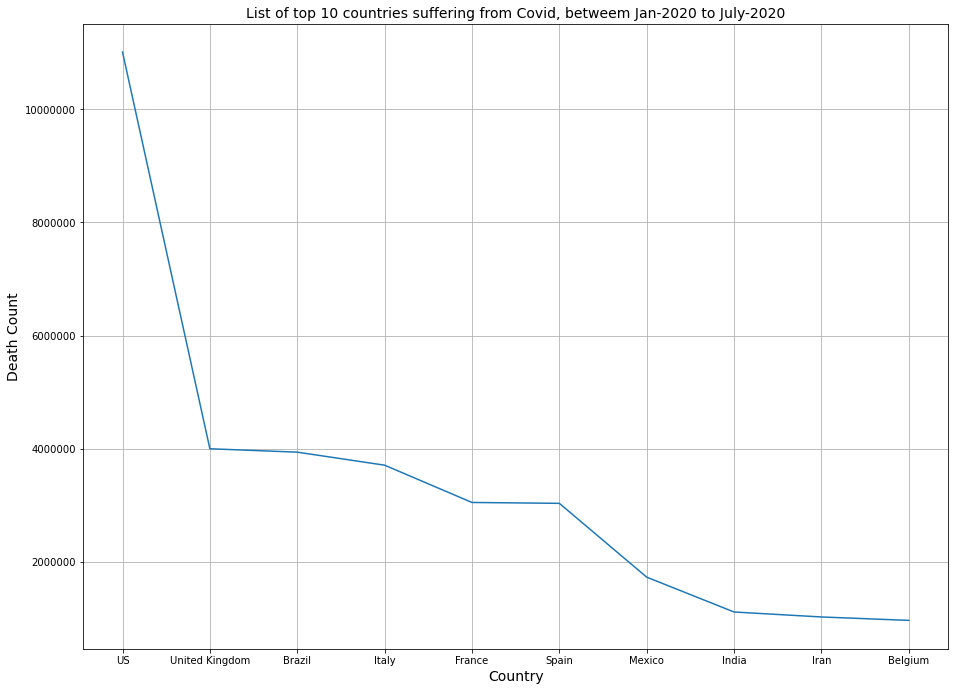

In [20]:
# Plotting the graph
import matplotlib.pyplot as plt
import numpy as np

country = suffer.toPandas().Country.values
deaths = suffer.toPandas().totalDeaths.values
country
fig = plt.gcf()
fig.set_size_inches(15.5, 11.5)

plt.plot(country, deaths)
plt.ticklabel_format(style='plain', axis='y')
plt.title('List of top 10 countries suffering from Covid, betweem Jan-2020 to July-2020', fontsize=14)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Death Count', fontsize=14)

plt.grid(True)
plt.show()      

# 6.	Plot the recovery rate (recovered cases / confirmed cases) for the period Jan 22, 2020 to July 27, 2020. Which 5 countries have a relatively higher recovery rate?

In [26]:
df.createOrReplaceTempView("recoveryRate")

In [27]:
# querying the data
df_recoveryRate = spark.sql("SELECT Country, SUM(Recovered / Confirmed) AS RecoveryRate FROM recoveryRate WHERE Date BETWEEN '2020-01-22' AND '2020-07-27' GROUP BY Country ORDER BY RecoveryRate DESC LIMIT 5") 
df_recoveryRate.show()

+--------------+------------------+
|       Country|      RecoveryRate|
+--------------+------------------+
|         China| 4656.851147887325|
|United Kingdom| 862.5994958001738|
|        France|  862.418118091109|
|     Australia| 856.7740016451787|
|   Netherlands|258.76313614208885|
+--------------+------------------+



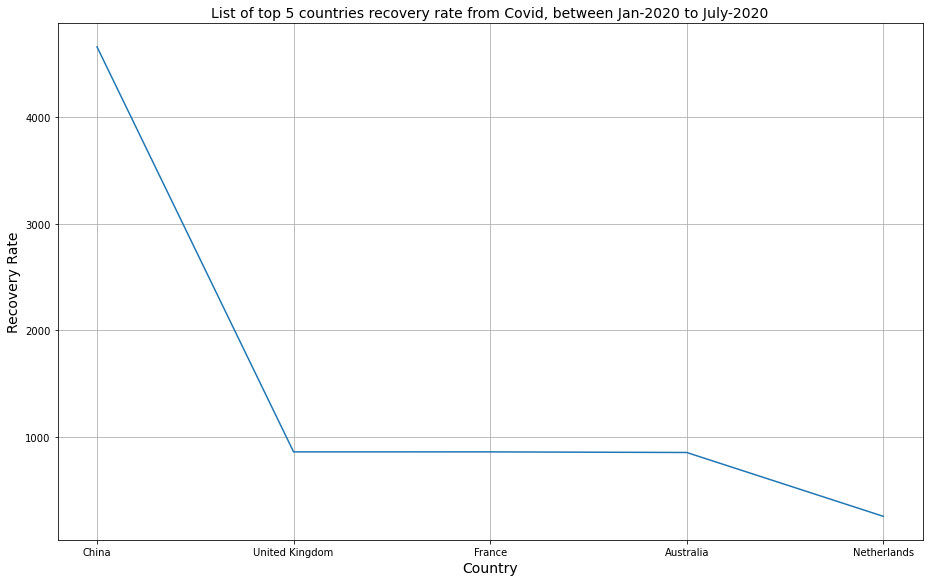

In [28]:
# graph plot
import matplotlib.pyplot as plt
import numpy as np

country = df_recoveryRate.toPandas().Country.values
recoveryRate = df_recoveryRate.toPandas().RecoveryRate.values
country

fig = plt.gcf()
fig.set_size_inches(15.5, 9.5)

plt.plot(country, recoveryRate)
plt.ticklabel_format(style='plain', axis='y')
plt.title('List of top 5 countries recovery rate from Covid, between Jan-2020 to July-2020', fontsize=14)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Recovery Rate', fontsize=14)

plt.grid(True)
plt.show() 

# 7. As of July 27, 2020, aggregate the confirmed cases, deaths, recovered cases and active cases group by WHO region

In [31]:
df.createOrReplaceTempView("byWHO")

In [32]:
df_byWho = spark.sql("SELECT WHORegion, SUM(Confirmed) AS ConfirmedCases, SUM(Deaths) AS Deaths, SUM(Recovered) AS RecoveredCases, SUM(ACtive) AS ActiveCases FROM byWHO WHERE DATE BETWEEN '2020-01-22' AND '2020-07-27' GROUP BY WHORegion")
df_byWho.show()

+--------------------+--------------+--------+--------------+-----------+
|           WHORegion|ConfirmedCases|  Deaths|RecoveredCases|ActiveCases|
+--------------------+--------------+--------+--------------+-----------+
|              Europe|     248879793|19271040|     123202075|  106406678|
|     Western Pacific|      26374411|  932430|      18861950|    6580031|
|              Africa|      21791827|  439978|      11193730|   10158119|
|Eastern Mediterra...|      74082892| 1924029|      48050703|   24108160|
|            Americas|     402261194|19359292|     157069444|  225832458|
|     South-East Asia|      55118365| 1458134|      30030327|   23629904|
+--------------------+--------------+--------+--------------+-----------+



# 8.	Which 5 countries have the highest growth rate on confirmed cases 3 months after the 1st positive case detected within the country?

In [23]:
# creating a temp view for growthRate
df.createOrReplaceTempView("growthRate")

In [24]:
# querying the data to get the first confirmed covid case in the country
df_growthRate = spark.sql("SELECT * FROM growthRate WHERE Confirmed = 1 ORDER BY Date ASC")
df_growthRate.show()

+-------+-----------+---------+---------+----------+---------+------+---------+------+---------------+
|  State|    Country| Latitude|Longitude|      Date|Confirmed|Deaths|Recovered|Active|      WHORegion|
+-------+-----------+---------+---------+----------+---------+------+---------+------+---------------+
|Guizhou|      China|  26.8154| 106.8748|2020-01-22|        1|     0|        0|     1|Western Pacific|
| Fujian|      China|  26.0789| 117.9874|2020-01-22|        1|     0|        0|     1|Western Pacific|
|   null|    Taiwan*|     23.7|    121.0|2020-01-22|        1|     0|        0|     1|Western Pacific|
|   null|         US|     40.0|   -100.0|2020-01-22|        1|     0|        0|     1|       Americas|
|  Macau|      China|  22.1667|   113.55|2020-01-22|        1|     0|        0|     1|Western Pacific|
|Ningxia|      China|  37.2692| 106.1655|2020-01-22|        1|     0|        0|     1|Western Pacific|
|  Anhui|      China|  31.8257| 117.2264|2020-01-22|        1|     0|    

In [29]:
# Removing the duplicate data from previous dataframe by Country and sorting the data by date, that way we get first 
# confirmed case date for each country
 
df_growthRateDuplicate = df_growthRate.drop_duplicates(['Country']).orderBy(["Date"], ascending=[1, 1])

# temp view for removing the duplicate date
df_growthRateDuplicate.createOrReplaceTempView("growthDropDup")

# spark.sql("SELECT * FROM growthDropDup").show(200)

# joining two views to get the growth rate, 3 months from first covid case Joining on the country, Latitude and longitude
# Formula used to calculate Growth Rate in period of 3 months 
# Present_Case = Present
# Past_Case = Past
# period = 3
# Formula : ((Present / Past) ^ 1/3) - 1)


df_growth = spark.sql("""SELECT b.Country,b.Date AS FirstCaseDate, a.Date AS PresentDate, a.Confirmed AS PresentConfirmedCases, round((POWER(a.Confirmed/b.Confirmed, 1/3) - 1), 2) AS GrowthRate 
                  FROM growthDropDup AS b 
                  FULL OUTER JOIN growthRate AS a
                  ON b.Country = a.Country AND b.Latitude = a.Latitude AND b.Longitude = a.Longitude 
                  WHERE a.Date = add_months(b.Date, 3)
                  ORDER BY GrowthRate DESC
                  LIMIT 5
                  """)
df_growth.show()

+-------+-------------+-----------+---------------------+----------+
|Country|FirstCaseDate|PresentDate|PresentConfirmedCases|GrowthRate|
+-------+-------------+-----------+---------------------+----------+
|     US|   2020-01-22| 2020-04-22|               837422|     93.26|
| Brazil|   2020-02-26| 2020-05-26|               391222|     72.14|
|  Spain|   2020-02-01| 2020-05-01|               215216|     58.93|
|   Peru|   2020-03-06| 2020-06-06|               191758|     56.67|
| Turkey|   2020-03-11| 2020-06-11|               174023|     54.83|
+-------+-------------+-----------+---------------------+----------+



# 9.	For step 7, export the results to a JSON file

In [ ]:
df_byWho.write.json("/tmp/spark_output/byWho.json")